In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

parent_path, current_path =  os.path.split(os.getcwd())
data_path = os.path.join(parent_path, "Data")
sys.path.append(parent_path)

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging as logger
from scipy import stats
import category_encoders as ce

from src.preprocess import date_process, read_csv, split_dataset
from src.transformer import ConTransform, CatHandlerHighCard, IdentityTransform
from src.nn_model import make_keras_model

pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

In [4]:
# Data Process
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
#Data Augmentation
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

# Correlation and Feature Reduction
from sklearn.decomposition import PCA
# Classifiers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM

# Regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Linear Models and NN
import keras
from keras.models import Sequential
from keras.layers import Dense

In [5]:
from src.revenue_model import RevenueModel

# Preprocessing Functions

In [6]:
total_df = read_csv(os.path.join(data_path, "train_data.csv"))
test_df = read_csv(os.path.join(data_path, "test_data.csv"))
total_df['full_cat'] = total_df[["cat1", "cat2", "cat3"]].agg('-'.join, axis=1)

In [7]:
tansformer_list = [
            ( "net_price", ConTransform()),
            ( "num1", ConTransform()),
            ( "num2", ConTransform()),
            ( "num3", ConTransform()),
            ( "num4", ConTransform()),
            ( "num5", ConTransform()),
            ( "num6", ConTransform()),
            ( "cat1", CatHandlerHighCard(30)),
            ( "cat2", CatHandlerHighCard(30)),
            ( "cat3", CatHandlerHighCard(30)),
            ( "weekday",CatHandlerHighCard(30))
            ]

# Candidate Models

In [17]:
# Grid Search For Best Model
# Prepare tuples purchase_model and revenue_model tuples
nn = KerasRegressor(make_keras_model, epochs=5, batch_size=1, verbose=0)
candidate_model_list = [
    ("lr+ridge", (
    Pipeline([("pca", PCA(n_components=0.9)), ("lr", LogisticRegression(n_jobs=-1,verbose=0))]),
    Pipeline([("pca", PCA(n_components=0.9)), ("r", Ridge())])
    )),
    ("gb+gb", (
    Pipeline([("pca", PCA(n_components=0.9)), ("gb", GradientBoostingClassifier(n_estimators=100))]),
    Pipeline([("pca", PCA(n_components=0.9)), ("gbr", GradientBoostingRegressor())])
    )),
    ("rf+rf", (
    Pipeline([("pca", PCA(n_components=0.9)), ("rf", RandomForestClassifier(n_jobs=-1))]),
    Pipeline([("pca", PCA(n_components=0.9)), ("rfr", RandomForestRegressor(n_jobs=-1))])
    )),
    ("gb+ridge", (
    Pipeline([("pca", PCA(n_components=0.9)), ("gb", GradientBoostingClassifier(n_estimators=100))]),
    Pipeline([("pca", PCA(n_components=0.9)), ("rige", Ridge())])
    )),
    ("lr+las", (
    Pipeline([("pca", PCA(n_components=0.9)), ("lr", LogisticRegression(n_jobs=-1,verbose=0))]),
    Pipeline([("pca", PCA(n_components=0.9)), ("r",  Lasso())])
    )),
    ("nb+ridge", (
    Pipeline([("pca", PCA(n_components=0.9)), ("nb", GaussianNB())]),
    Pipeline([("pca", PCA(n_components=0.9)), ("r", Ridge())])
    )),
    ("rf+nn", (
    Pipeline([("pca", PCA(n_components=0.9)), ("rf", RandomForestClassifier(n_jobs=-1))]),
    Pipeline([("pca", PCA(n_components=0.9)), ("nn", nn)])
    ))
]

# Experiments

In [18]:
model_objects = []
report_list = []
epochs = 5
other_sampling = False
for name, candidate_model in candidate_model_list[:4]: #Shorted due to lack of time.
    model_samples = list()
    print(name)
    for i in range(epochs):
        revenue_model = RevenueModel(purchase_model=candidate_model[0],
                            revenue_model=candidate_model[1],
                             transformer_list=tansformer_list)
        revenue_model.train(total_df.copy())
        df = revenue_model.get_report()
        df["model"] = name
        df["iteration"] = i
        df["sample_ratio"] = 0.5
        report_list.append(df)
        model_samples.append(revenue_model)
        if other_sampling:
            revenue_model = RevenueModel(purchase_model=candidate_model[0],
                                revenue_model=candidate_model[1],
                                 transformer_list=tansformer_list)
            revenue_model.train(total_df.copy(), sampling="under",sampling_strategy=0.25)
            df = revenue_model.get_report()
            df["model"] = name
            df["iteration"] = i
            df["sample_ratio"] = 0.25
            report_list.append(df)
            model_samples.append(revenue_model)
    model_objects.append(model_samples)
report_df = pd.concat(report_list)

lr+ridge
gb+gb
rf+rf
gb+ridge


In [19]:
report_df = pd.concat(report_list)

In [20]:
report_df.to_csv("results.csv", index=False)

# Results

In [21]:
report_df.groupby(["model", "sample_ratio"]).agg(["mean","median","min","max"])

f1_micro                                f1_macro  \
                           mean    median       min       max      mean   
model    sample_ratio                                                     
gb+gb    0.5           0.891734  0.893785  0.877944  0.904542  0.488570   
gb+ridge 0.5           0.899459  0.892691  0.882348  0.918758  0.491325   
lr+ridge 0.5           0.891793  0.889175  0.882141  0.907586  0.487939   
rf+rf    0.5           0.845152  0.842864  0.836776  0.857346  0.473869   

                                                    f1_weighted            \
                         median       min       max        mean    median   
model    sample_ratio                                                       
gb+gb    0.5           0.489612  0.482921  0.492516    0.934571  0.935744   
gb+ridge 0.5           0.487594  0.486354  0.499964    0.938832  0.935119   
lr+ridge 0.5           0.487857  0.482530  0.493025    0.934600  0.933174   
rf+rf    0.5           0.473675  0.471056  0.477348    0.907992  0.906674   

                                                auc                      \
                            min       max      mean    median       min   
model    sample_ratio                                                     
gb+gb    0.5           0.926856  0.941679  0.661746  0.661002  0.630991   
gb+ridge 0.5           0.929356  0.949415  0.659463  0.664482  0.645873   
lr+ridge 0.5           0.929205  0.943341  0.672730  0.675687  0.655792   
rf+rf    0.5           0.903082  0.915098  0.643414  0.645283  0.619333   

                                perfect_r2                                \
                            max       mean    median       min       max   
model    sample_ratio                                                      
gb+gb    0.5           0.684755   0.413136  0.440787  0.322602  0.462863   
gb+ridge 0.5           0.674903   0.454649  0.449672  0.425177  0.500585   
lr+ridge 0.5           0.686710   0.462144  0.414721  0.351545  0.611756   
rf+rf    0.5           0.666841   0.406256  0.401846  0.348469  0.453822   

                      perfect_mape                               perfect_mae  \
                              mean    median       min       max        mean   
model    sample_ratio                                                          
gb+gb    0.5              0.531685  0.519658  0.507851  0.587666   48.547648   
gb+ridge 0.5              0.501986  0.496593  0.451100  0.566978   47.218278   
lr+ridge 0.5              0.568734  0.560707  0.539724  0.624636   48.758247   
rf+rf    0.5              0.552903  0.563237  0.475976  0.629328   55.811843   

                                                       perfect_pearson  \
                          median        min        max            mean   
model    sample_ratio                                                    
gb+gb    0.5           48.410502  43.304999  52.962567        0.665257   
gb+ridge 0.5           46.566881  41.045968  54.774118        0.701909   
lr+ridge 0.5           48.346017  45.932618  52.518510        0.703500   
rf+rf    0.5           54.235309  51.954525  61.434961        0.681099   

                                                           r2            \
                         median       min       max      mean    median   
model    sample_ratio                                                     
gb+gb    0.5           0.675216  0.604253  0.689908 -6.499154 -5.624773   
gb+ridge 0.5           0.703233  0.682405  0.724933 -8.274265 -8.558285   
lr+ridge 0.5           0.671365  0.615801  0.810592 -6.781056 -6.635038   
rf+rf    0.5           0.694373  0.617169  0.717042 -6.603491 -6.982422   

                                                    mape                \
                             min       max          mean        median   
model    sample_ratio                                                    
gb+gb    0.5           -8.899327 -5.373713  1.533223e+17  1.521546e+17

In [13]:
revenue_model.vis()

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     33537
           1       0.02      0.30      0.03       300

    accuracy                           0.84     33837
   macro avg       0.50      0.57      0.47     33837
weighted avg       0.98      0.84      0.90     33837



In [23]:
revenue_model.r_dev_y.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='net_revenue', ylabel='Density'>

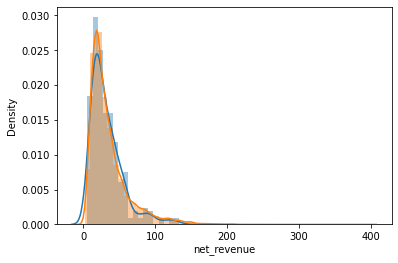

In [24]:
sns.distplot(revenue_model.r_dev_prediction[revenue_model.r_dev_y >0 ], label="NoZero")
sns.distplot(revenue_model.r_dev_prediction[revenue_model.r_dev_y == 0], label="Zero")

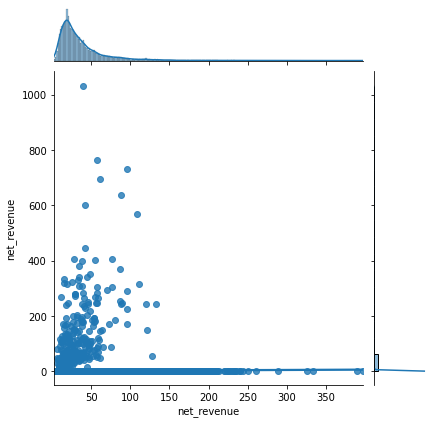

In [25]:
from scipy import stats
sns.jointplot(revenue_model.r_dev_prediction, revenue_model.r_dev_y, kind="reg")

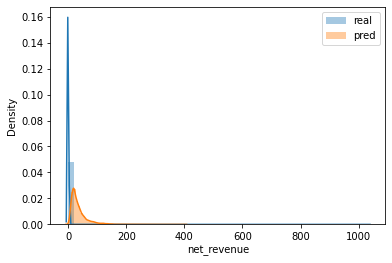

In [26]:
sns.distplot(revenue_model.r_dev_y, label="real")
sns.distplot(revenue_model.r_dev_prediction,label="pred")
plt.legend()

# Test Prediction

In [41]:
test_model = model_objects[0][1]
test_prediction_df = pd.DataFrame({"prediction":revenue_model.predict(test_df)})

In [47]:
test_prediction_df.to_csv("LinearModel_test_prediction.csv", index=False)

Text(0.5, 1.0, 'Prediction Distribution')

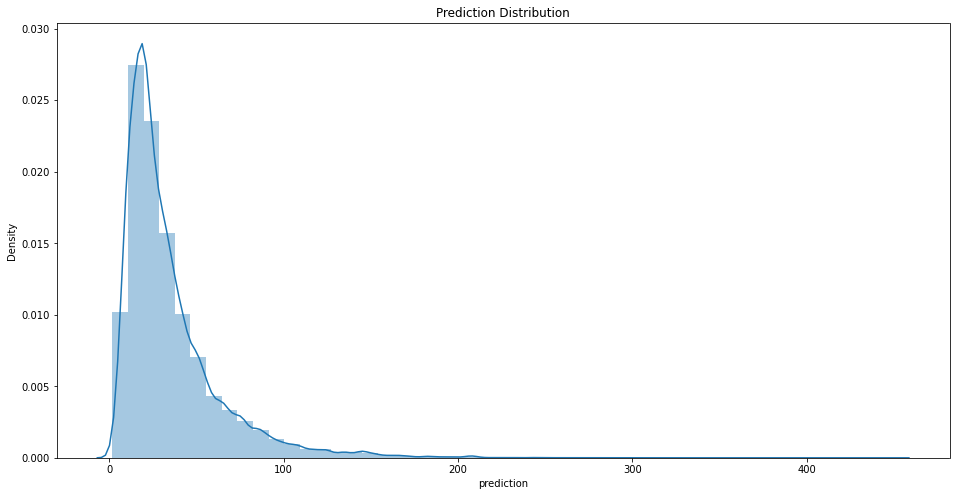

In [46]:
plt.figure(figsize=(16,8))
sns.distplot(test_prediction_df.prediction)
plt.title("Prediction Distribution")

# As expected, it is right skewed.